In [31]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg) if 'loss' in metric_type else np.max(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'train_target_misclassification': get_mean_metrics(models, 'train_target_misclassification'),
        'test_target_misclassification': get_mean_metrics(models, 'test_target_misclassification')
    }

    return baseline_metrics

In [32]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [33]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_AB35IN_25R_19_01', 'MNIST_AB__IN_25R_20_00']

In [34]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_AB35IN_25R_19_01


In [35]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_AB__IN_25R_20_00


In [36]:
models = client.list_models(session_id)

num_rounds = models['count']
# num_rounds

# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [37]:
# client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']

In [38]:
# json.loads(client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']['data'])

In [39]:
# for round in range(num_rounds):
#     for client_model in client.list_validations(modelId = model_trail[round]['model']).keys():
#         print(json.loads(client.list_validations(modelId = model_trail[round]['model'])[client_model]['data'])['train_target_misclassification'])

In [40]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'train_target_misclassification': json.loads(worker_result['data'])['train_target_misclassification'],
            'test_target_misclassification': json.loads(worker_result['data'])['test_target_misclassification'],
            'train_target_prediction_dist': json.loads(worker_result['data'])['train_target_prediction_dist'],
            'test_target_prediction_dist': json.loads(worker_result['data'])['test_target_prediction_dist']
        }
        
        validations.append(validation)

In [41]:
validations[0]

{'model_committed_at': 'Wed, 08 May 2024 09:24:16 GMT',
 'session_id': 'MNIST_AB35IN_25R_19_01',
 'model': 'fce4037e-b33d-433d-9ff1-d05ac7760979',
 'client_name': 'benign_client12',
 'client_role': 'WORKER',
 'client_type': 'benign',
 'train_target_misclassification': 0.9932659932659933,
 'test_target_misclassification': 1.0,
 'train_target_prediction_dist': [77, 0, 29, 16, 169, 0, 0, 1, 2, 3],
 'test_target_prediction_dist': [8, 0, 4, 0, 36, 0, 0, 0, 0, 0]}

In [42]:
graph_data = {
    'train_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'train_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_train_target_misclassification': [],
    'overall_test_target_misclassification': [],
    'overall_train_target_prediction_dist': [],
    'overall_test_target_prediction_dist': []
}

In [43]:
for validation in validations:
    graph_data['train_target_misclassification'][validation['client_name']]['data'].append(validation['train_target_misclassification'])
    graph_data['test_target_misclassification'][validation['client_name']]['data'].append(validation['test_target_misclassification'])
    graph_data['train_target_prediction_dist'][validation['client_name']]['data'].append(validation['train_target_prediction_dist'])
    graph_data['test_target_prediction_dist'][validation['client_name']]['data'].append(validation['test_target_prediction_dist'])

In [44]:
graph_data['train_target_prediction_dist']

{'benign_client2': {'data': [[67, 0, 30, 14, 169, 0, 0, 0, 0, 10],
   [110, 0, 2, 3, 69, 0, 0, 3, 84, 19],
   [105, 0, 0, 2, 4, 0, 0, 5, 165, 9],
   [103, 0, 0, 1, 1, 0, 3, 6, 172, 4],
   [71, 0, 0, 0, 1, 0, 11, 6, 196, 5],
   [36, 1, 0, 1, 1, 0, 25, 5, 214, 7],
   [17, 1, 0, 1, 1, 0, 32, 5, 221, 12],
   [8, 1, 0, 2, 4, 7, 32, 3, 216, 17],
   [4, 6, 1, 4, 4, 11, 27, 2, 214, 17],
   [4, 8, 3, 6, 7, 20, 12, 2, 211, 17],
   [4, 10, 6, 8, 7, 17, 5, 2, 215, 16],
   [4, 9, 6, 10, 6, 15, 4, 2, 219, 15],
   [3, 8, 6, 11, 4, 13, 4, 2, 225, 14],
   [3, 7, 5, 10, 5, 16, 4, 2, 225, 13],
   [3, 7, 6, 10, 5, 16, 4, 2, 224, 13],
   [3, 7, 5, 11, 5, 16, 4, 2, 223, 14],
   [3, 7, 5, 12, 5, 15, 4, 2, 224, 13],
   [3, 9, 5, 11, 4, 15, 4, 2, 225, 12],
   [3, 10, 5, 9, 4, 14, 4, 2, 227, 12],
   [3, 10, 6, 10, 4, 13, 4, 2, 227, 11],
   [3, 10, 6, 10, 5, 12, 4, 2, 228, 10],
   [2, 10, 7, 10, 5, 11, 4, 2, 230, 9],
   [2, 10, 8, 8, 4, 13, 4, 2, 230, 9],
   [2, 10, 8, 9, 4, 13, 4, 1, 230, 9]],
  'type': 'benign

In [45]:
graph_data['overall_train_target_misclassification'] = [np.mean([graph_data['train_target_misclassification'][key]['data'][i] for key in graph_data['train_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_target_misclassification'] = [np.mean([graph_data['test_target_misclassification'][key]['data'][i] for key in graph_data['test_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_train_target_prediction_dist'] = [np.sum([graph_data['train_target_prediction_dist'][key]['data'][i] for key in graph_data['train_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]
graph_data['overall_test_target_prediction_dist'] = [np.sum([graph_data['test_target_prediction_dist'][key]['data'][i] for key in graph_data['test_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]

In [46]:
graph_data['overall_test_target_prediction_dist']

[[228, 0, 71, 43, 593, 0, 0, 6, 5, 28],
 [337, 0, 2, 18, 223, 0, 1, 8, 331, 54],
 [349, 1, 0, 3, 27, 0, 3, 19, 545, 27],
 [334, 1, 0, 1, 5, 0, 14, 24, 585, 10],
 [220, 0, 0, 1, 4, 0, 38, 27, 670, 14],
 [120, 0, 0, 1, 4, 0, 74, 31, 722, 22],
 [67, 2, 0, 1, 4, 0, 102, 33, 728, 37],
 [37, 16, 1, 5, 11, 12, 97, 21, 719, 55],
 [23, 29, 2, 16, 19, 28, 75, 16, 704, 62],
 [12, 36, 4, 26, 28, 44, 53, 16, 700, 55],
 [10, 39, 5, 28, 29, 55, 45, 15, 701, 47],
 [7, 34, 9, 29, 29, 60, 32, 14, 717, 43],
 [6, 30, 10, 29, 29, 65, 27, 11, 727, 40],
 [5, 29, 10, 28, 27, 66, 24, 10, 737, 38],
 [5, 29, 12, 25, 27, 70, 23, 10, 737, 36],
 [4, 27, 11, 29, 26, 73, 25, 9, 734, 36],
 [4, 26, 11, 25, 26, 74, 24, 10, 739, 35],
 [4, 23, 12, 27, 24, 73, 22, 9, 746, 34],
 [5, 23, 12, 28, 23, 71, 20, 9, 751, 32],
 [5, 22, 14, 26, 22, 71, 19, 9, 757, 29],
 [6, 22, 14, 27, 21, 71, 18, 8, 759, 28],
 [6, 22, 11, 28, 21, 71, 18, 8, 763, 26],
 [6, 21, 11, 28, 21, 69, 17, 8, 769, 24],
 [6, 21, 10, 27, 20, 71, 17, 8, 772, 22]

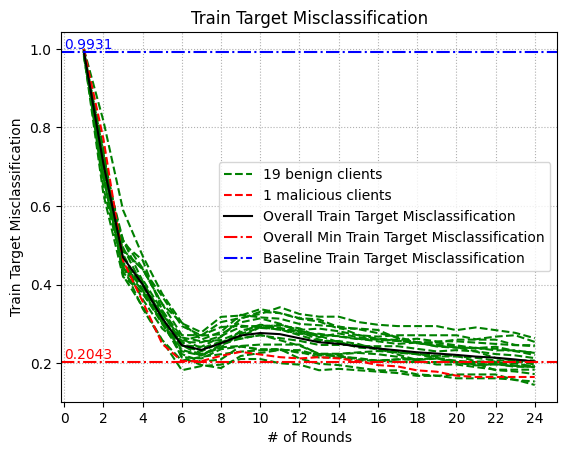

In [47]:
x = range(1, num_rounds + 1)
metric_type = "train_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

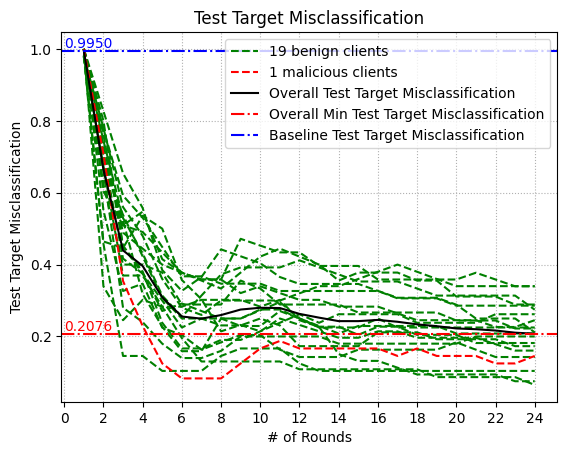

In [48]:
x = range(1, num_rounds + 1)
metric_type = "test_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()